# Generating synthetic data sets of a river bed column forced by monoperiodic river and aquifer temperature signals

2024 developped by the student group from ``demo_genData.ipynb`` created by Nicolas Flipo during MOLONARI 2024 and ``demo_Pyheatmy.ipynb``.

The object of this demo is to test the validity of our MCMC inversion.

In order to do so, we first generate a virtual point and its data thanks to ``demo_genData.ipynb`` and then inverse those data to find the parameters of the point. We can then see if we find back the parameters we used to generate the virtual point. 

In [1]:
from pyheatmy import *
import pandas as pd

NBITER = 10

## Génération et traitement d'un jeu de données virtuelles

On exécute le notebook ``demo_genData.ipynb`` pour générer un jeu de données dont on connaîtra les caractéristiques.

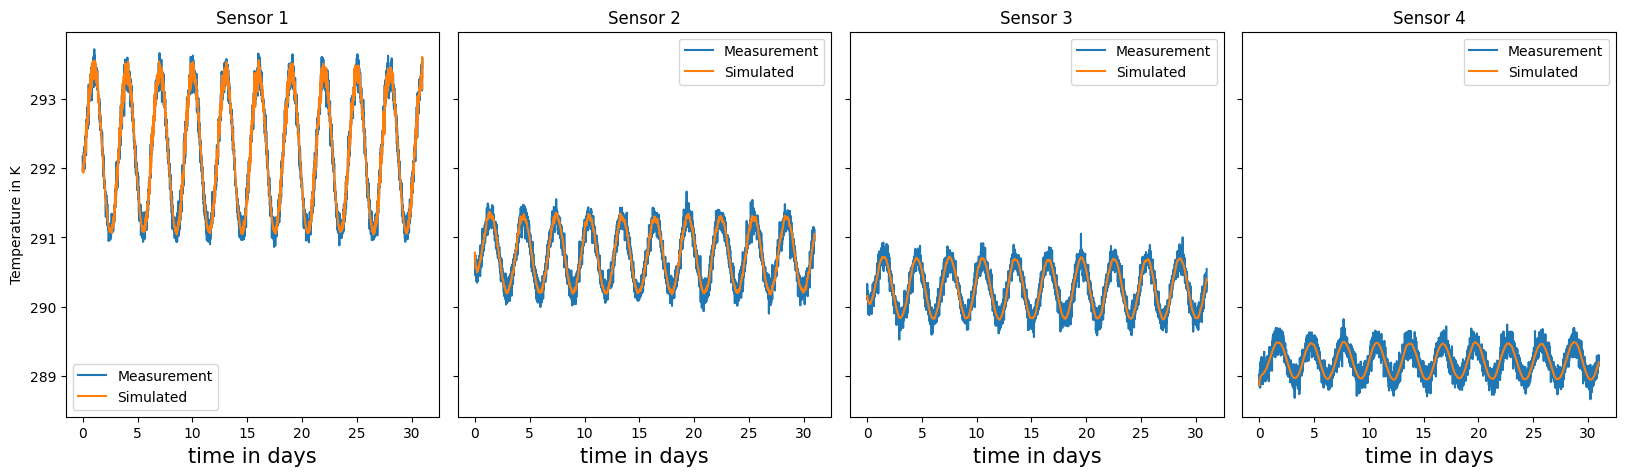

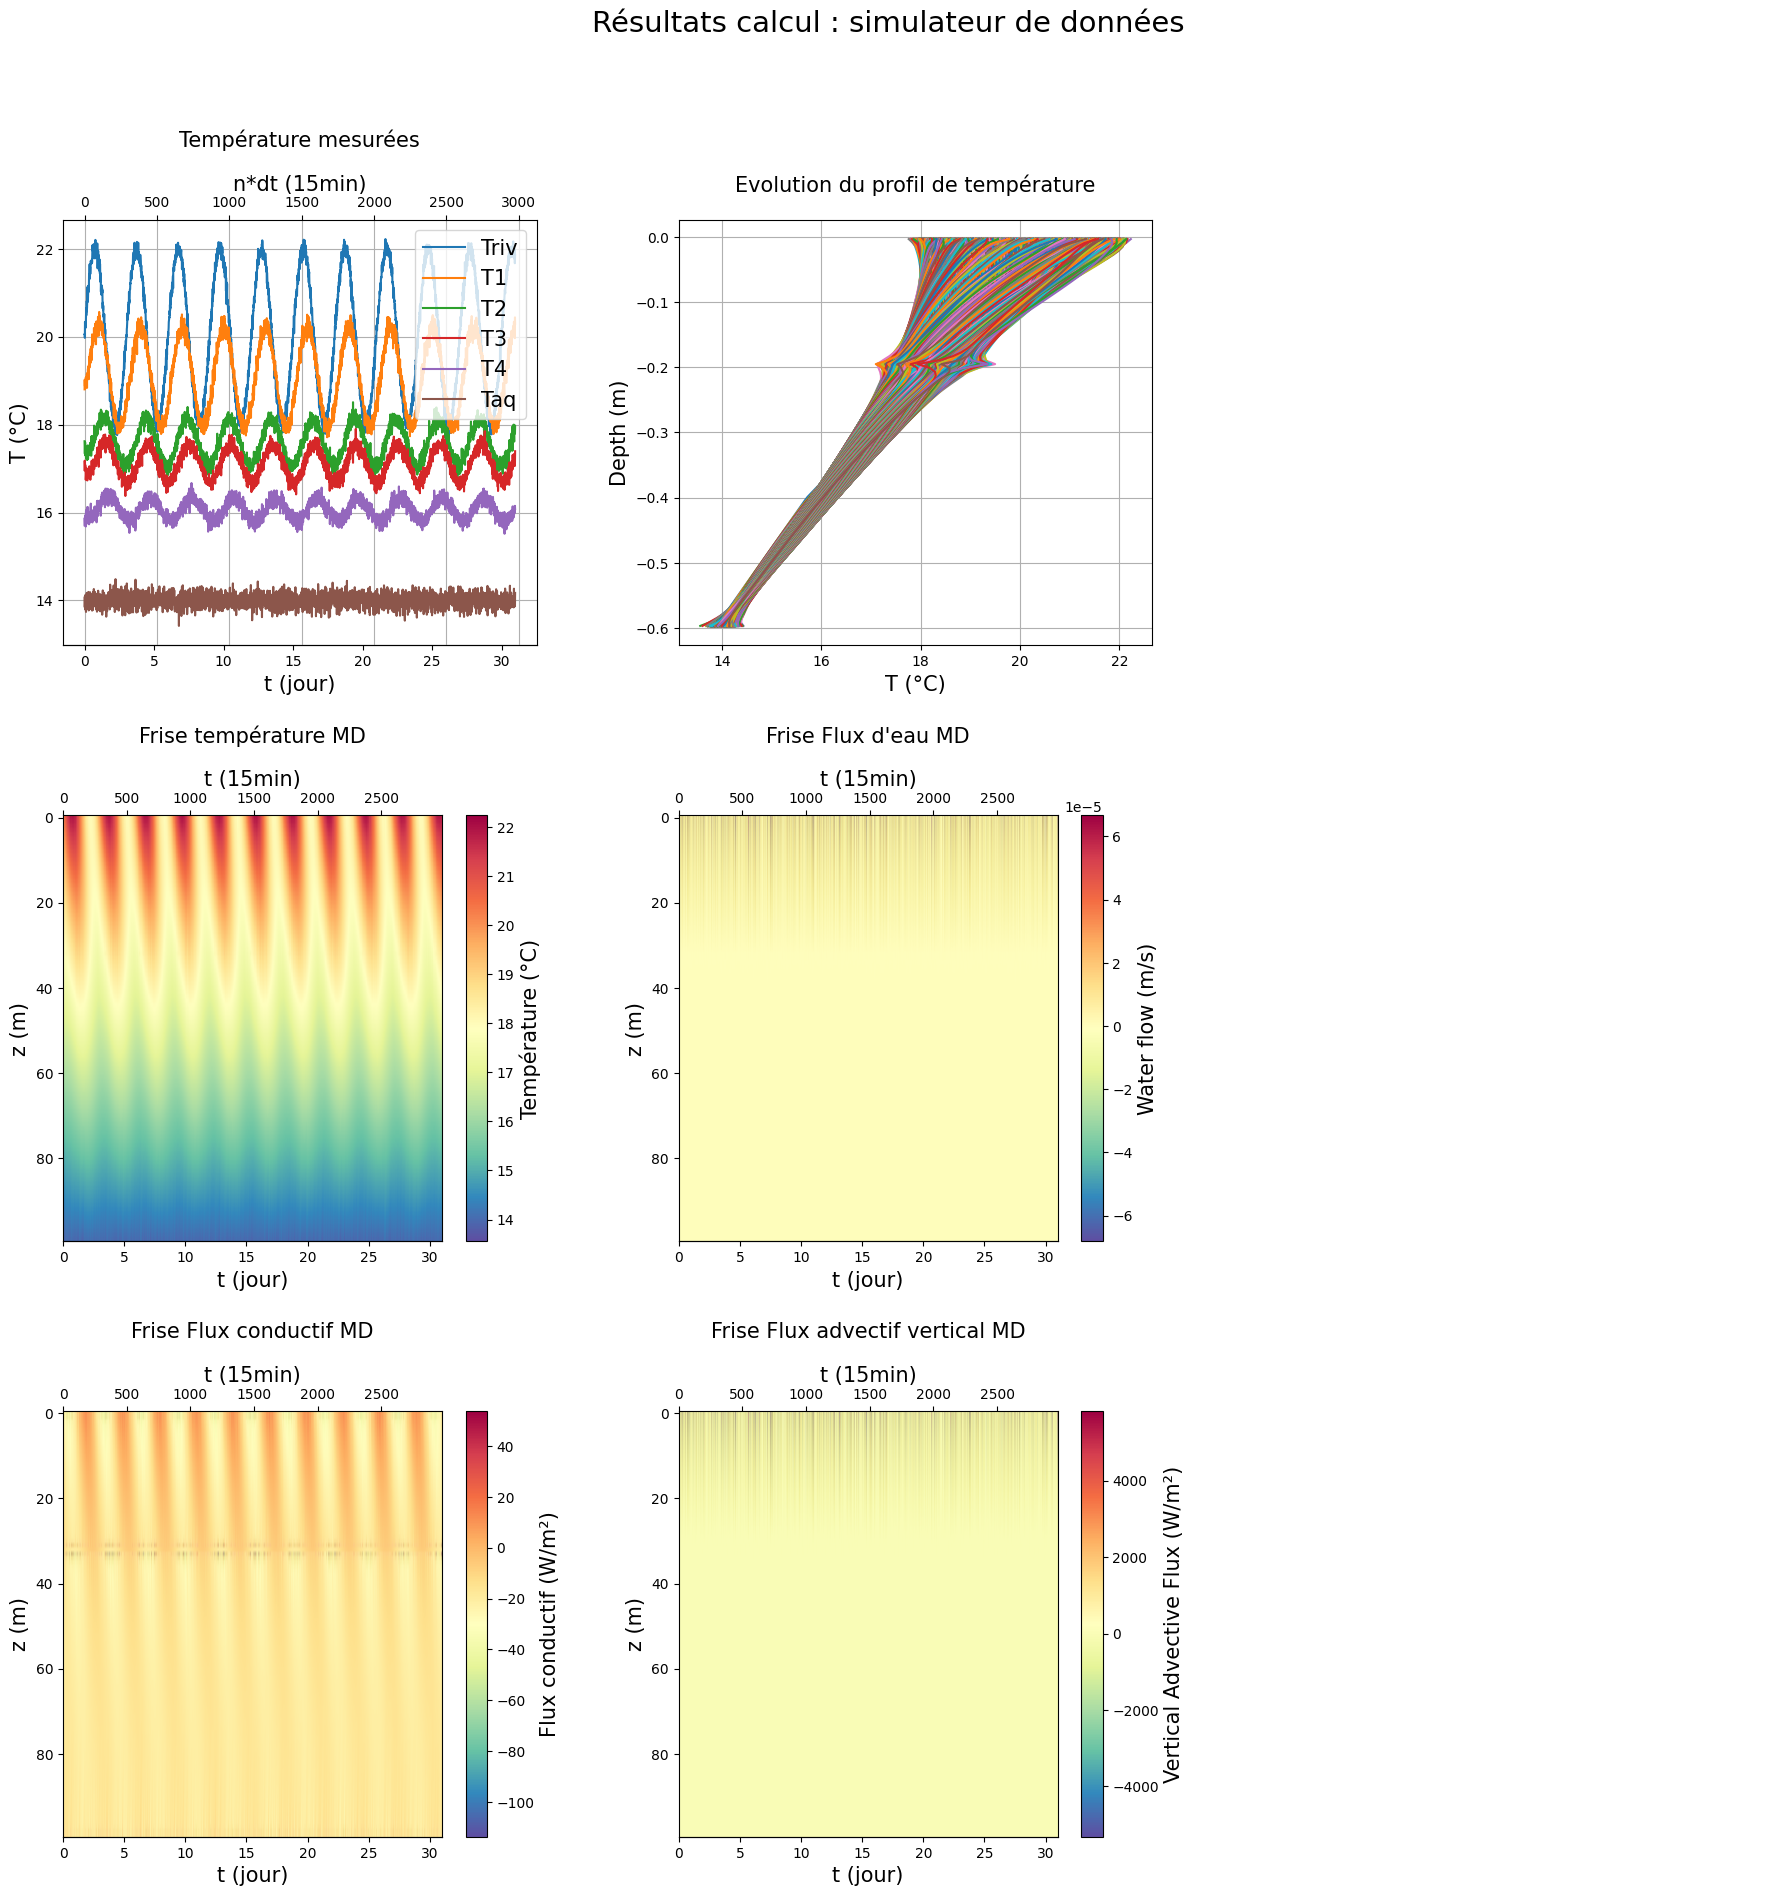

In [2]:
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
from IPython.display import display, clear_output

path_demoGenData = "demo_genData.ipynb"

# Fonction pour exécuter un notebook
def run_notebook(notebook_path):
    # Charger le notebook
    with open(notebook_path) as f:
        notebook = nbformat.read(f, as_version=4)

    # Configurer l'ExecutePreprocessor pour exécuter toutes les cellules
    ep = ExecutePreprocessor(timeout=600, kernel_name='python3')

    # Exécuter le notebook
    try:
        ep.preprocess(notebook, {'metadata': {'path': './'}})
        print("Notebook exécuté avec succès.")
    except Exception as e:
        print(f"Erreur lors de l'exécution du notebook : {e}")

# Fonction pour importer les valeurs des cellules de code d'un notebook dans le contexte global
def import_notebook_values(notebook_path):
    # Charger le notebook
    with open(notebook_path) as f:
        notebook = nbformat.read(f, as_version=4)

    # Créer un dictionnaire pour contenir les variables globales du notebook
    notebook_globals = {}

    try:
        # Exécuter chaque cellule de code
        for cell in notebook.cells:
            if cell.cell_type == 'code':
                exec(cell.source, notebook_globals)
                
        # Maintenant, importer les variables du notebook dans l'espace global
        globals().update(notebook_globals)  # Met à jour l'espace global avec les variables du notebook
        print("Les valeurs du notebook sont maintenant accessibles.")
        
    except Exception as e:
        print(f"Erreur lors de l'exécution du notebook : {e}")

run_notebook(path_demoGenData)
print("")
print("Affichage temporaire")
print("")
import_notebook_values(path_demoGenData)
clear_output()

On extrait ensuite et traite les données générées par le notebook, de la même façon qu'elles sont traitées dans ``demo_Pyheatmy.ipynb``.

In [3]:
# define the folder path
folder = col._dir_print + '/VirtualPoint'

# read the data
capteur_riviere = pd.read_csv(folder + "/VirtualPoint_P_measures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv(folder + "/VirtualPoint_T_measures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [4]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [5]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


dH : [(Timestamp('2011-08-01 00:00:00'), (0.7815533400114189, 566.348)), (Timestamp('2011-08-01 00:15:00'), (0.7810059264476119, 566.3476)), (Timestamp('2011-08-01 00:30:00'), (0.7809176092909719, 566.4635)), (Timestamp('2011-08-01 00:45:00'), (0.7805446574518204, 566.6361999999999)), (Timestamp('2011-08-01 01:00:00'), (0.7804326983681996, 566.6608)), (Timestamp('2011-08-01 01:15:00'), (0.7815868459037467, 566.7882999999999)), (Timestamp('2011-08-01 01:30:00'), (0.7812512429786086, 567.0659)), (Timestamp('2011-08-01 01:45:00'), (0.7821529199074184, 566.9429)), (Timestamp('2011-08-01 02:00:00'), (0.7823918851004619, 567.18)), (Timestamp('2011-08-01 02:15:00'), (0.7830273713072523, 567.1321)), (Timestamp('2011-08-01 02:30:00'), (0.7820060325676328, 567.3399)), (Timestamp('2011-08-01 02:45:00'), (0.7820661163286028, 567.5352)), (Timestamp('2011-08-01 03:00:00'), (0.7811222097853326, 567.6162999999999)), (Timestamp('2011-08-01 03:15:00'), (0.7826696531612074, 567.4556)), (Timestamp('2011-0

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [6]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

## Inversion des données générées

On va maintenant inverser les données générées pour obtenir les différentes caractéristiques.

In [ ]:
NBITERMCMC = 20

priors = {
    "Prior_moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "Prior_n": ((.01, .25), .01),
    "Prior_lambda_s": ((1, 10), .1),
    "Prior_rhos_cs": ((1e6,1e7), 1e5),
    "Prior_q_s": ((1e-9, 1e-5), 1e-10),
}

Layer_homogenous = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q_s": 1e-5
}

Layer_homogenous = Layer.from_dict(Layer_homogenous)

# On crée une couche de référence pour la comparaison plus bas
reference_params_dict = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q_s": 1e-5
}

layer_for_simulation = Layer.from_dict(reference_params_dict)

col.set_layers(Layer_homogenous)
Layer_homogenous.set_priors_from_dict(priors)
print(Layer_homogenous.Prior_list)


col.all_layers

col.compute_mcmc(
    nb_iter = NBITERMCMC,
    verbose=False
)

bestLayers = col.get_best_layers()

col.plot_all_param_pdf()


In [ ]:
import matplotlib.pyplot as plt

q_s_samples = col.get_all_params()[0][::, 4]


fig, ax = plt.subplots()
fig.set_size_inches(4, 5)
ax.hist(q_s_samples, bins=10) 
ax.axvline(x=Couche["q_s"], color='r', linestyle='--', label='Valeur réelle de q_s')
ax.legend()
ax.set_title("Distribution de q_s")
ax.set_xlabel("q_s")
ax.set_ylabel("Itérations")

## Comparaison des paramètres réels et de ceux inversés

On peut à présent comparer les données inversées et celles orignales.

In [ ]:
import pandas as pd

# --- ÉTAPE 1 : ACTION (inchangée) ---
col.get_best_layers()

# --- ÉTAPE 2 : RÉCUPÉRATION (inchangée) ---
inverted_params = col.get_list_current_params()[0]

# --- ÉTAPE 3 : COMPARAISON (corrigée) ---
# On utilise maintenant le dictionnaire de référence pour les "vraies" valeurs.
data = {
    'Paramètre': PARAM_LIST,
    'Valeur de Référence': [
        reference_params_dict['moinslog10IntrinK'], # ✅ On utilise le dictionnaire original
        reference_params_dict['n'],
        reference_params_dict['lambda_s'],
        reference_params_dict['rhos_cs'],
        reference_params_dict['q_s']
    ],
    'Valeur Inversée (MCMC)': [
        inverted_params.moinslog10IntrinK,
        inverted_params.n,
        inverted_params.lambda_s,
        inverted_params.rhos_cs,
        inverted_params.q_s
    ]
}

# Créer et afficher le tableau de comparaison
comparison_df = pd.DataFrame(data)

# Appliquer un formatage pour une meilleure lisibilité
comparison_df['Valeur de Référence'] = comparison_df['Valeur de Référence'].map('{:.3e}'.format)
comparison_df['Valeur Inversée (MCMC)'] = comparison_df['Valeur Inversée (MCMC)'].map('{:.3e}'.format)

print("--- Comparaison des paramètres de référence et inversés ---")
print(comparison_df.to_string(index=False))

## Test dans le cas où la valeur de $q_s$ est fixéee

Inversion des données générées avec un $q_s$ fixé

In [8]:
NBITERMCMC = 20

priors = {
    "Prior_moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "Prior_n": ((.01, .25), .01),
    "Prior_lambda_s": ((1, 10), .1),
    "Prior_rhos_cs": ((1e6,1e7), 1e5),
    "Prior_q_s": (1e-5, 0), # Valeur fixe, sigma=0 par convention mais il est ignoré dans ce cas
}

Layer_homogenous = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q_s": 1e-5
}

Layer_homogenous = Layer.from_dict(Layer_homogenous)

# On crée une couche de référence pour la comparaison plus bas
reference_params_dict = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q_s": 1e-5
}

layer_for_simulation = Layer.from_dict(reference_params_dict)

col.set_layers(Layer_homogenous)
Layer_homogenous.set_priors_from_dict(priors)
print(Layer_homogenous.Prior_list)


col.all_layers

col.compute_mcmc(
    nb_iter = NBITERMCMC,
    verbose=False
)

bestLayers = col.get_best_layers()

col.plot_all_param_pdf()


[Prior sur une valeur qui évolue entre 11 et 16 avec un écart type de 0.01, Prior sur une valeur qui évolue entre 0.01 et 0.25 avec un écart type de 0.01, Prior sur une valeur qui évolue entre 1 et 10 avec un écart type de 0.1, Prior sur une valeur qui évolue entre 1000000.0 et 10000000.0 avec un écart type de 100000.0, Prior avec une valeur fixe : 1e-05]
Initialisation - Utilisation de la mémoire (en Mo) : 633.50784


Burn in phase:   4%|▍         | 1/25 [00:01<00:42,  1.77s/it]


ValueError: probabilities contain NaN

In [ ]:
q_s_samples = col.get_all_params()[0][::, 4]


fig, ax = plt.subplots()
fig.set_size_inches(4, 5)
ax.hist(q_s_samples, bins=10) 
ax.axvline(x=Couche["q_s"], color='r', linestyle='--', label='Valeur réelle de q_s')
ax.legend()
ax.set_title("Distribution de q_s")
ax.set_xlabel("q_s")
ax.set_ylabel("Itérations")

In [ ]:
import pandas as pd

# --- ÉTAPE 1 : ACTION (inchangée) ---
col.get_best_layers()

# --- ÉTAPE 2 : RÉCUPÉRATION (inchangée) ---
inverted_params = col.get_list_current_params()[0]

# --- ÉTAPE 3 : COMPARAISON (corrigée) ---
# On utilise maintenant le dictionnaire de référence pour les "vraies" valeurs.
data = {
    'Paramètre': PARAM_LIST,
    'Valeur de Référence': [
        reference_params_dict['moinslog10IntrinK'], # ✅ On utilise le dictionnaire original
        reference_params_dict['n'],
        reference_params_dict['lambda_s'],
        reference_params_dict['rhos_cs'],
        reference_params_dict['q_s']
    ],
    'Valeur Inversée (MCMC)': [
        inverted_params.moinslog10IntrinK,
        inverted_params.n,
        inverted_params.lambda_s,
        inverted_params.rhos_cs,
        inverted_params.q_s
    ]
}

# Créer et afficher le tableau de comparaison
comparison_df = pd.DataFrame(data)

# Appliquer un formatage pour une meilleure lisibilité
comparison_df['Valeur de Référence'] = comparison_df['Valeur de Référence'].map('{:.3e}'.format)
comparison_df['Valeur Inversée (MCMC)'] = comparison_df['Valeur Inversée (MCMC)'].map('{:.3e}'.format)

print("--- Comparaison des paramètres de référence et inversés ---")
print(comparison_df.to_string(index=False))